In [37]:
import pandas as pd

In [49]:
df_train = pd.read_csv("./data/train.csv")
df = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18876\1660835522.py:1: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("./data/train.csv")
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18876\1660835522.py:2: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/train.csv")
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18876\1660835522.py:3: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv("./data/test.csv")


In [39]:
set(df_train.columns) - set(df_test.columns)

{'Listing.Price.ClosePrice'}

In [41]:
X = df_train.drop('Listing.Price.ClosePrice', axis=1)
Y = df_train['Listing.Price.ClosePrice']


X_test = df_test


In [42]:
df_train.shape

(107437, 55)

In [43]:
print(df_test.isna().sum())

Characteristics.LotFeatures               13050
Characteristics.LotSizeSquareFeet         21765
ImageData.c1c6.summary.bathroom            2652
ImageData.c1c6.summary.exterior            4563
ImageData.c1c6.summary.interior            2235
ImageData.c1c6.summary.kitchen             2395
ImageData.c1c6.summary.property            1017
ImageData.features_reso.results             621
ImageData.q1q6.summary.bathroom            2654
ImageData.q1q6.summary.exterior            5807
ImageData.q1q6.summary.interior            2233
ImageData.q1q6.summary.kitchen             2395
ImageData.q1q6.summary.property            1168
ImageData.room_type_reso.results            235
ImageData.style.exterior.summary.label     5607
ImageData.style.stories.summary.label      5404
Listing.Dates.CloseDate                       0
Listing.ListingId                             0
Location.Address.CensusBlock               1122
Location.Address.CensusTract               1122
Location.Address.City                   

In [15]:
import missingno as msno

In [60]:
df_train['Listing.Dates.CloseDate']

0         2023-12-22T00:00:00
1         2023-09-19T00:00:00
2         2023-12-04T00:00:00
3         2023-08-01T00:00:00
4         2023-09-20T00:00:00
                 ...         
107432    2024-03-18T00:00:00
107433    2023-10-26T00:00:00
107434    2024-06-14T00:00:00
107435    2024-01-26T00:00:00
107436    2024-01-17T00:00:00
Name: Listing.Dates.CloseDate, Length: 107437, dtype: object

<Axes: >

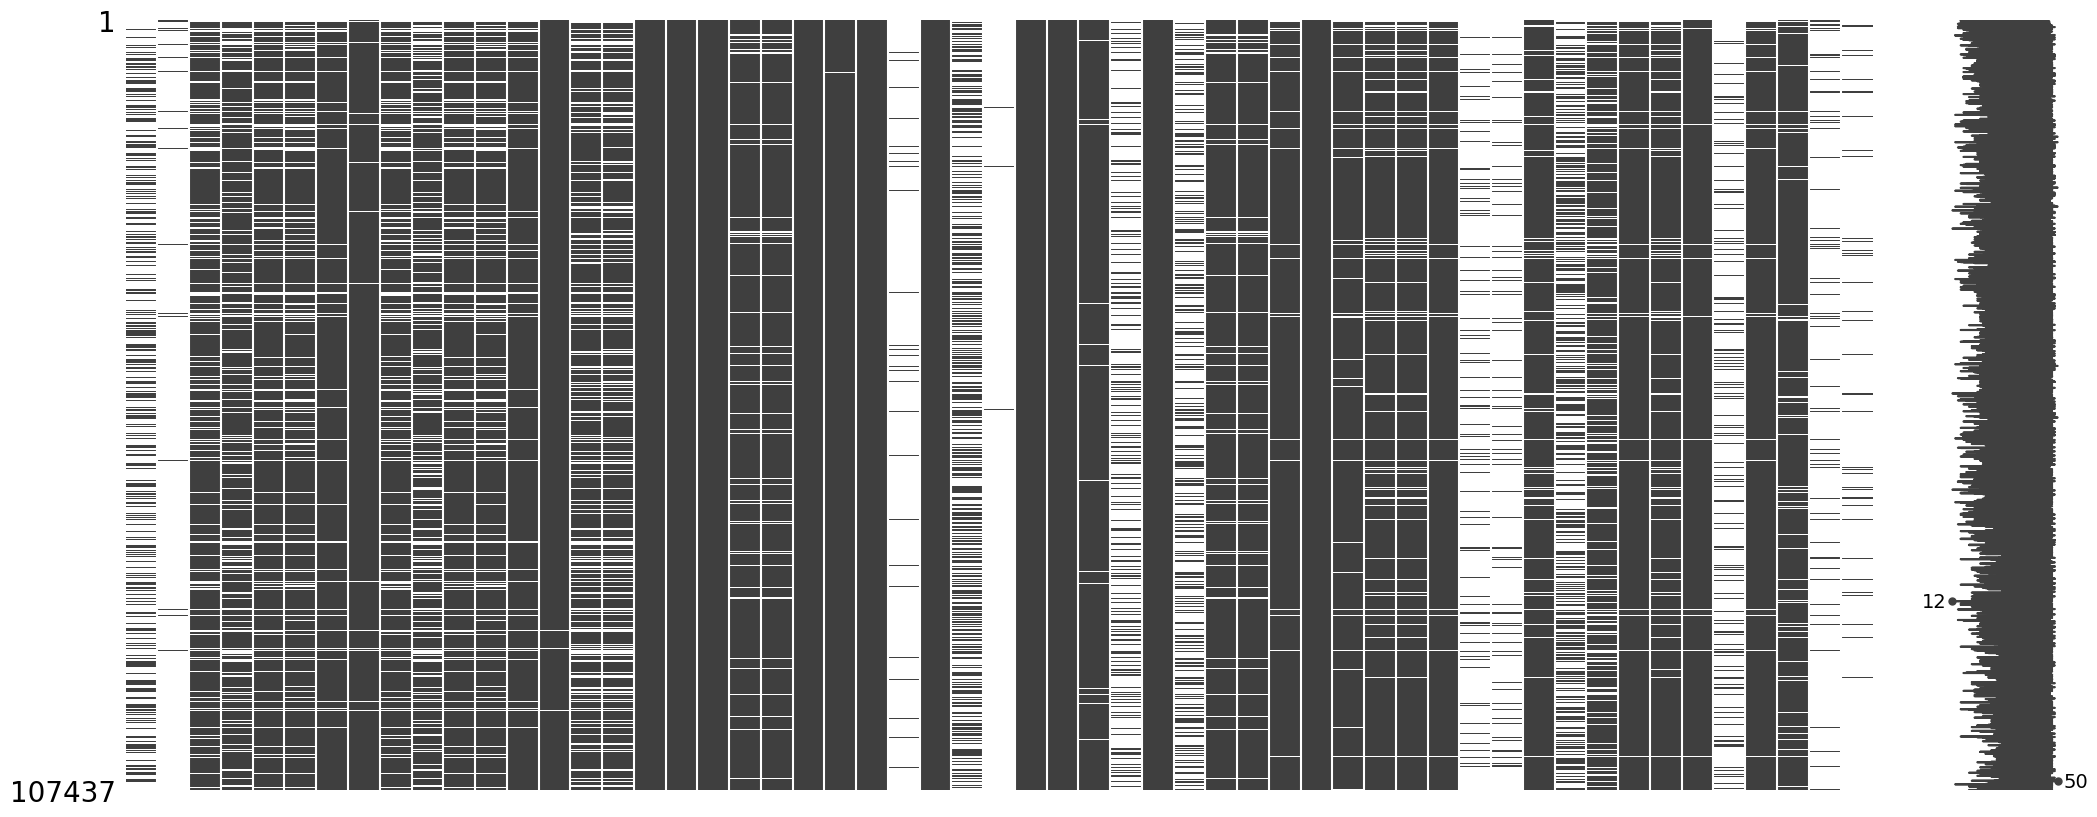

In [17]:
msno.matrix(df_train)

In [20]:
df_train["Listing.Price.ClosePrice"]

0           30000.0
1          399000.0
2         2050000.0
3          162000.0
4         3225000.0
            ...    
107432     169900.0
107433    1250000.0
107434    1800000.0
107435    1025000.0
107436     358205.0
Name: Listing.Price.ClosePrice, Length: 107437, dtype: float64

In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
import shap
from datetime import datetime
import re
from sklearn.metrics import mean_squared_error, r2_score
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder



class HousePricePrediction:
    def __init__(self):
        self.label_encoders = {}
        self.numerical_imputer = None
        self.categorical_imputer = None
        self.model = None
        
    def preprocess_features(self, df):
        """Comprehensive feature preprocessing and engineering"""
        df = df.copy()
        
        # 1. Date Processing
        df['Listing.Dates.CloseDate'] = pd.to_datetime(df['Listing.Dates.CloseDate'])
        df['CloseDate_Month'] = df['Listing.Dates.CloseDate'].dt.month
        df['CloseDate_Year'] = df['Listing.Dates.CloseDate'].dt.year
        df['CloseDate_Season'] = df['Listing.Dates.CloseDate'].dt.month.map({
            12: 'Winter', 1: 'Winter', 2: 'Winter',
            3: 'Spring', 4: 'Spring', 5: 'Spring',
            6: 'Summer', 7: 'Summer', 8: 'Summer',
            9: 'Fall', 10: 'Fall', 11: 'Fall'
        })
        
        # 2. Location Features
        # Create location clusters based on lat/long
        mask = df[['Location.GIS.Latitude', 'Location.GIS.Longitude']].notna().all(axis=1)
        if mask.any():
            from sklearn.cluster import KMeans
            coords = df.loc[mask, ['Location.GIS.Latitude', 'Location.GIS.Longitude']]
            kmeans = KMeans(n_clusters=10, random_state=42)
            df.loc[mask, 'location_cluster'] = kmeans.fit_predict(coords)
            df['location_cluster'] = df['location_cluster'].fillna(-1)
        
        # 3. Address Features
        df['has_unit'] = df['Location.Address.UnitNumber'].notna().astype(int)
        
        # 4. Property Features
        # Total bathrooms
        df['total_bathrooms'] = df['Structure.BathroomsFull'].fillna(0) + 0.5 * df['Structure.BathroomsHalf'].fillna(0)
        
        # Living space ratios
        df['basement_ratio'] = (df['Structure.BelowGradeFinishedArea'].fillna(0) / 
                              df['Structure.LivingArea'].replace(0, np.nan))
        
        # Room density
        df['room_density'] = (df['Structure.Rooms.RoomsTotal'].fillna(0) / 
                            df['Structure.LivingArea'].replace(0, np.nan))
        
        # Age of the property
        current_year = datetime.now().year
        df['property_age'] = current_year - df['Structure.YearBuilt'].fillna(current_year)
        
        # 5. Parse and Process Image Data Features
        # Process RESO features
        def extract_features(x):
            if pd.isna(x):
                return []
            try:
                return eval(x) if isinstance(x, str) else x
            except:
                return []
                
        df['feature_count'] = df['ImageData.features_reso.results'].apply(
            lambda x: len(extract_features(x)))
        
        # Process quality and condition scores
        quality_cols = [col for col in df.columns if 'q1q6.summary' in col]
        condition_cols = [col for col in df.columns if 'c1c6.summary' in col]
        
        df['avg_quality'] = df[quality_cols].mean(axis=1)
        df['avg_condition'] = df[condition_cols].mean(axis=1)
        
        # 6. Create interaction features
        df['price_per_sqft'] = df['Listing.Price.ClosePrice'] / df['Structure.LivingArea']
        df['rooms_per_bathroom'] = (df['Structure.Rooms.RoomsTotal'].fillna(0) / 
                                  df['total_bathrooms'].replace(0, np.nan))
        
        # 7. Target encoding for high-cardinality categoricals
        categorical_cols = [
            'Location.Address.City',
            'Location.School.HighSchoolDistrict',
            'Property.PropertyType'
        ]
        
        self.target_encoder = ce.TargetEncoder(cols=categorical_cols)
        if 'Listing.Price.ClosePrice' in df.columns:  # Only fit during training
            self.target_encoder.fit(df[categorical_cols], 
                                  df['Listing.Price.ClosePrice'])
            
        encoded_cats = self.target_encoder.transform(df[categorical_cols])
        df = df.join(encoded_cats.add_suffix('_encoded'))
        
        return df
    
    def prepare_features(self, df):
        """Prepare final feature set for modeling"""
        # Define feature groups
        numerical_features = [
            'Structure.LivingArea',
            'Structure.BedroomsTotal',
            'total_bathrooms',
            'Structure.GarageSpaces',
            'Characteristics.LotSizeSquareFeet',
            'feature_count',
            'avg_quality',
            'avg_condition',
            'property_age',
            'Location.GIS.Latitude',
            'Location.GIS.Longitude',
            'Location.Address.City_encoded',
            'Location.School.HighSchoolDistrict_encoded'
        ]
        
        categorical_features = [
            'Property.PropertyType',
            'Structure.Heating',
            'Structure.Cooling',
            'CloseDate_Season',
            'location_cluster'
        ]
        
        # Create preprocessing pipeline
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ])

        
        # Combine transformers
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numerical_features),
                ('cat', categorical_transformer, categorical_features)
            ]
        )

        
        # Fit and transform
        if self.model is None:  # Training phase
            X = self.preprocessor.fit_transform(df)
        else:  # Prediction phase
            X = self.preprocessor.transform(df)
            
        feature_names = (numerical_features + 
                        [f"{col}_encoded" for col in categorical_features])
        
        return X, feature_names
    
    def train(self, df):
        """Train the model"""
        # Preprocess features
        df_processed = self.preprocess_features(df)
        
        # Prepare features for modeling
        X, feature_names = self.prepare_features(df_processed)
        y = df_processed['Listing.Price.ClosePrice']
        
        # Split data
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        # Train model
        self.model = GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )
        
        self.model.fit(X_train, y_train)
        
        # Calculate performance metrics
        train_pred = self.model.predict(X_train)
        val_pred = self.model.predict(X_val)
        
        metrics = {
            'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
            'val_rmse': np.sqrt(mean_squared_error(y_val, val_pred)),
            'train_r2': r2_score(y_train, train_pred),
            'val_r2': r2_score(y_val, val_pred)
        }
        
        # Generate SHAP values for interpretability

        print(f"X_val dtype: {X_val.dtype}")


        explainer = shap.TreeExplainer(self.model)
        if hasattr(X_val, "toarray"):  # Check if the output is sparse
            X_val = X_val.toarray()
        self.shap_values = explainer.shap_values(np.array(X_val, dtype=float))  # Ensure numeric type

        self.feature_names = feature_names
        
        return metrics
    
    def predict(self, df):
        """Make predictions on new data"""
        df_processed = self.preprocess_features(df)
        X, _ = self.prepare_features(df_processed)
        return self.model.predict(X)
    
    def get_feature_importance(self):
        """Get feature importance analysis"""
        # Extract transformed feature names
        if hasattr(self.preprocessor, 'get_feature_names_out'):
            transformed_feature_names = self.preprocessor.get_feature_names_out()
        else:
            transformed_feature_names = self.feature_names  # Fallback
        
        # Ensure alignment with model feature importances
        if len(transformed_feature_names) != len(self.model.feature_importances_):
            raise ValueError("Feature names and model importances length mismatch!")
        
        # Create a DataFrame
        importance_df = pd.DataFrame({
            'feature': transformed_feature_names,
            'importance': self.model.feature_importances_
        })
        return importance_df.sort_values('importance', ascending=False)

    
    def get_shap_analysis(self):
        """Get SHAP value analysis"""
        if hasattr(self.preprocessor, 'get_feature_names_out'):
            feature_names = self.preprocessor.get_feature_names_out()
        else:
            feature_names = self.feature_names  # Fallback
        
        if len(self.shap_values[0]) != len(feature_names):
            raise ValueError("SHAP values and feature names length mismatch!")
        
        return {
            'shap_values': self.shap_values,
            'feature_names': feature_names
        }

# Example usage
if __name__ == "__main__":
    # Assuming df is your DataFrame
    model = HousePricePrediction()
    metrics = model.train(df)
    print("Model Performance:", metrics)
    
    # Get feature importance
    importance_df = model.get_feature_importance()
    print("\nTop 10 Most Important Features:")
    print(importance_df.head(10))
    
    # Get SHAP analysis
    shap_analysis = model.get_shap_analysis()

X_val dtype: float64
Model Performance: {'train_rmse': 172499.20123440845, 'val_rmse': 189349.6010914, 'train_r2': 0.8040543367039767, 'val_r2': 0.7402944980258803}

Top 10 Most Important Features:
                                            feature  importance
2                              num__total_bathrooms    0.316243
6                                  num__avg_quality    0.175271
11               num__Location.Address.City_encoded    0.100233
0                         num__Structure.LivingArea    0.091720
9                        num__Location.GIS.Latitude    0.057484
10                      num__Location.GIS.Longitude    0.055034
12  num__Location.School.HighSchoolDistrict_encoded    0.037196
8                                 num__property_age    0.027986
5                                num__feature_count    0.024897
1                      num__Structure.BedroomsTotal    0.016854


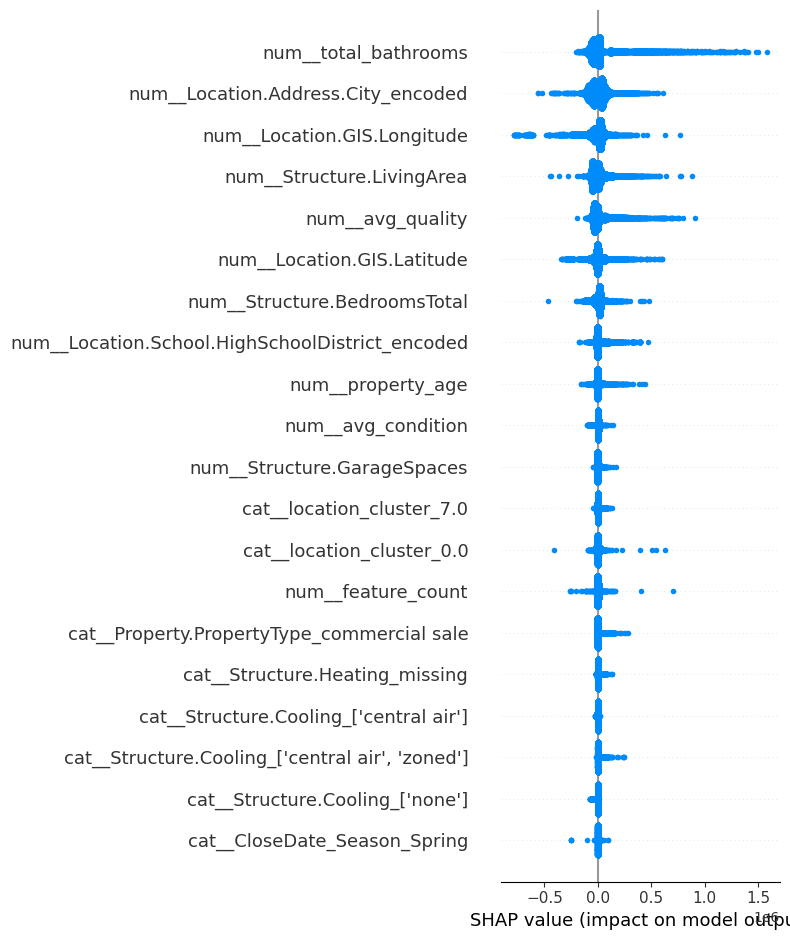

In [58]:
shap.summary_plot(
    shap_analysis['shap_values'],
    feature_names=shap_analysis['feature_names']
)

In [34]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
    --------------------------------------- 0.0/1.4 MB 660.6 kB/s eta 0:00:03
   ----- ---------------------------------- 0.2/1.4 MB 2.5 MB/s eta 0:00:01
   ------------------ --------------------- 0.7/1.4 MB 5.2 MB/s eta 0:00:01
   -------------------------------- ------- 1.2/1.4 MB 7.4 MB/s eta 0:00:01
   ---------------------------------------  1.4/1.4 MB 7.7 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 6.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\Usuario\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
